## Symbolic Aggregate Approximation

### 1.  [reference](http://dl.acm.org/citation.cfm?id=1285965)
### 2. main usage for time series data:
1. indexing and query
2. calculating distance between time-sereis and thus perform clustering/classification
3. symbolic representation for time series - inspiring text-mining related tasks such as association mining
4. vector representation of time-series
    
### 3. algorithm steps

1. Segment time-series data into gapless pieces (e.g., gap introduced by missing values or change of sampling frequences)

2. Each piece will be SAXed into a sequence of "words" (e.g., "abcdd" "aabcd", ...). This is done by rolling a sliding window of length $window$ with a stride of length $stride$. If $stride$ < $window$, there will be overlapping of different windows. Later each window will be converted into one word

3. for each sliding window:

    3.1 whiten/normalize across the window (it is the step key to many problems)
    
    3.2 discretize on time axis (index) by grouping points into equal-sized bins (bin sizes could be fractional) - controlled by $nbins$. For each bin, use the mean of bin as local approximation.
    
    3.3 discretize on value axis by dividing values into $nlevels$ quantiles (equiprobability), for each level, calculate the "letter" by $cutpoint$ table
    
    3.4 at the end, each bin in a sliding window will be mapped to a letter, each window in the piece of time-series will be mapped to a word, and the whole piece of series will be a sentence
    
    3.5 calcualte the distance between two symoblic representations by their corresponding levels
    
    3.6 if a vector representation is necessary, each letter can be mapped to a scalar value, such as the mean of the  corresponding level.

## sax module test

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pysax
import numpy as np
reload(pysax)


<module 'pysax' from 'pysax.pyc'>

In [3]:
sax = pysax.SAXModel(window=3, stride=2) 
sax.sym2vec

{'A': -0.67, 'B': -0.335, 'C': 0.335, 'D': 0.67}

In [4]:
## test normalization
sax = pysax.SAXModel(window=3, stride=2) 
list(sax.sliding_window_index(10))
ws = np.random.random(10)
print ws.mean(), ws.std()
ss = sax.whiten(ws)
print ss.mean(), ss.std() 

0.361470138594 0.270188127993
-2.22044604925e-17 0.99999999963


In [5]:
## explore binning

from fractions import Fraction
def binpack(xs, nbins):
    xs = np.asarray(xs)
    binsize = Fraction(len(xs), nbins)
    wts = [1 for _ in xrange(int(binsize))] + [binsize-int(binsize)]
    pos = 0
    while pos < len(xs):
        if wts[-1] == 0:
            n = len(wts) - 1
        else:
            n = len(wts)
        yield zip(xs[pos:(pos+n)], wts[:n])
        pos += len(wts) - 1
        rest_wts = binsize-(1-wts[-1])
        wts = [1-wts[-1]] + [1 for _ in xrange(int(rest_wts))] + [rest_wts-int(rest_wts)]
        
xs = range(0, 16)
print list(binpack(xs, 5))
xs = range(0, 16)
print list(binpack(xs, 4))
xs = range(0, 5)
print list(binpack(xs, 3))

[[(0, 1), (1, 1), (2, 1), (3, Fraction(1, 5))], [(3, Fraction(4, 5)), (4, 1), (5, 1), (6, Fraction(2, 5))], [(6, Fraction(3, 5)), (7, 1), (8, 1), (9, Fraction(3, 5))], [(9, Fraction(2, 5)), (10, 1), (11, 1), (12, Fraction(4, 5))], [(12, Fraction(1, 5)), (13, 1), (14, 1), (15, 1)]]
[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, Fraction(1, 1)), (5, 1), (6, 1), (7, 1)], [(8, Fraction(1, 1)), (9, 1), (10, 1), (11, 1)], [(12, Fraction(1, 1)), (13, 1), (14, 1), (15, 1)]]
[[(0, 1), (1, Fraction(2, 3))], [(1, Fraction(1, 3)), (2, 1), (3, Fraction(1, 3))], [(3, Fraction(2, 3)), (4, 1)]]


In [6]:
## test binning
sax = pysax.SAXModel(nbins=3) 
print list(sax.binpack(np.ones(5)))
print 
print list(sax.binpack(np.ones(9)))

[array([1.0, 0.6666666666666666], dtype=object), array([0.3333333333333333, 1.0, 0.3333333333333333], dtype=object), array([0.6666666666666666, 1.0], dtype=object)]

[array([ 1.,  1.,  1.]), array([1.0, 1.0, 1.0], dtype=object), array([1.0, 1.0, 1.0], dtype=object)]


In [7]:
## explore symbolization
import pandas as pd
cutpoints = [-np.inf, -0.43, 0.43, np.inf]
xs = np.random.random(10)
v = pd.cut(xs, bins = cutpoints, labels=["A", "B", "C"])
v

[B, C, B, B, B, B, B, C, C, C]
Categories (3, object): [A < B < C]

In [8]:
xs = np.random.randn(10)
print xs
sax = pysax.SAXModel(window=3, stride=2) 
sax.symbolize(xs)

[-2.46602885  0.39134296  1.70215119  0.29374208 -0.57687444  1.36748039
 -0.75180416  1.40641149 -0.0255657   1.30817964]


[A, C, D, C, B, D, A, D, B, D]
Categories (4, object): [A < B < C < D]

In [9]:
sax = pysax.SAXModel(nbins = 5, alphabet="ABCD")
xs = np.random.randn(20) * 2 + 1.
print xs
sax.symbolize_window(xs)

[ 1.90920987  0.41399952  2.14886912  4.83136506  2.51270575 -1.37389647
  0.37520218 -0.19730388 -3.06401127  0.80359765  1.56664598  1.44602011
 -1.97262396  3.05136781  3.83575669  1.34578569  0.31728715  3.14381769
 -0.60718129 -1.46109601]


'DBBCB'

['CCBBB', 'DBCBB', 'BCBBD', 'BBACC', 'BBCBC', 'CBACC', 'CACCC', 'ACCCB', 'CCBCA', 'CBBAD', 'BBBCC', 'BCCCB', 'CBBBC', 'BACCC', 'ACCCB', 'BBDBB', 'CCBCB']


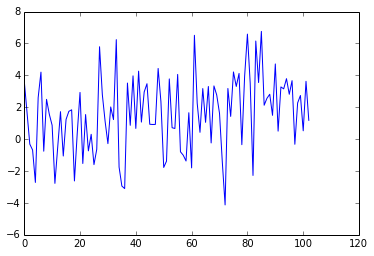

In [10]:
sax = pysax.SAXModel(window=20, stride = 5, nbins = 5, alphabet="ABCD")
xs = np.random.randn(103) * 2 + np.arange(103) * 0.03
plt.plot(xs)
print sax.symbolize_signal(xs)

In [15]:
import pysax
import numpy as np 
reload(pysax)
sax = pysax.SAXModel(window=20, stride = 5, nbins = 5, alphabet="ABCD")
xs = np.random.randn(1000000) * 2 + np.arange(1000000) * 0.03
#plt.plot(xs)
%time psymbols = sax.symbolize_signal(xs, parallel="joblib", n_jobs=4)


save temp file at /tmp/tmpCDX1ls
CPU times: user 4.01 s, sys: 239 ms, total: 4.25 s
Wall time: 38.2 s


In [ ]:
sax = pysax.SAXModel(window=20, stride = 5, nbins = 5, alphabet="ABCD")
#xs = np.random.randn(1000000) * 2 + np.arange(1000000) * 0.03
#plt.plot(xs)
%time symbols = sax.symbolize_signal(xs)
print np.all(psymbols==symbols)

In [21]:
## test symbol to vector
%time vecs = sax.symbol_to_vector(psymbols)
vecs.shape

CPU times: user 648 ms, sys: 15.4 ms, total: 664 ms
Wall time: 649 ms


(199997, 5)

In [67]:
## test symbol distance
reload(pysax)
sax = pysax.SAXModel(window=20, stride = 5, nbins = 5, alphabet="ABCD")
sax.symbol_distance(psymbols[0], psymbols[1]), sax.symbol_distance(psymbols[1], psymbols[2])

(0.94752308678997377, 1.6411581276647296)

In [68]:
v1, v2, v3 = sax.symbol_to_vector(psymbols[:3])

In [69]:
np.sqrt(np.sum( (v1-v2)**2 )), np.sqrt(np.sum( (v2-v3)**2 ))

(1.5712892795408491, 2.0650786909946075)

In [70]:
psymbols[:3]

['ABCDB', 'ACCBD', 'DACCB']